# Principal Component Analysis
Principal component analysis is a technique used to pick out the primary contributions to a spectrum (well that is how I am using it) called eigenspectra. My idea is the following:
- Use PCA to decompose multi-temperature X-ray spectra
- Train a machine learning algorithm to determine the number of temperature emission profiles in a spectra

In [26]:
from sklearn.decomposition import PCA, KernelPCA, FastICA
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import confusion_matrix
from sklearn import preprocessing
import matplotlib.pyplot as plt
from astropy.io import fits
import seaborn as sns
import numpy as np
import random
import pickle
import os

## Training the Algorithm
Here we are training our algorithm against data with a signal-to-noise value of 150. 
- The temperature varies between 0.1-4 keV
- The metalicity varies between 0.2 - 1.0 Z_solar. With a given spectra, all thermal components have the same metallicity
- Between 1 and 2 underlying temperature components

In [7]:
data_dir = '/path/to/synthetic'
syn_name = 'spec_'  # Prefix for synthetic data
syn_num = 2000  # Number of synthetic data
syn_ext = '.fits'  # Extension for synthetic data
n_components = 25  # Number of components we are interested in picking out using PCA
output_dir = '/home/carterrhea/Desktop'#'/path/to/output'
# Change Directories
os.chdir(data_dir)

In [9]:
# Read in Spectral Data using astropy
chan_min = 0  # Minimum value for channel
chan_max = 600  # Maximum value for channel
Counts = []
Counts_init = []
for spec_ct in list(range(syn_num)):
    if spec_ct%100 == 0:
        print('We are on spectrum number %i'%spec_ct)
    spec = fits.open(syn_name+str(spec_ct)+syn_ext)
    spec = spec[1].data
    vals = list(spec[chan_min:chan_max][:])
    channel = list(list(zip(*vals))[0])
    counts = list(list(zip(*vals))[1])
    Counts_init.append(counts)    
    # Normalize Data
    counts_max = np.max(counts)
    counts_norm = [count/counts_max for count in counts]
    Counts.append(counts_norm)

We are on spectrum number 0
We are on spectrum number 100
We are on spectrum number 200
We are on spectrum number 300
We are on spectrum number 400
We are on spectrum number 500
We are on spectrum number 600
We are on spectrum number 700
We are on spectrum number 800
We are on spectrum number 900
We are on spectrum number 1000
We are on spectrum number 1100
We are on spectrum number 1200
We are on spectrum number 1300
We are on spectrum number 1400
We are on spectrum number 1500
We are on spectrum number 1600
We are on spectrum number 1700
We are on spectrum number 1800
We are on spectrum number 1900


In [14]:
# Read in labels
Labels = []
with open('/your/path/here/tracking_stn150.txt','r') as f_lab:
    # Step through each line -> spectra
    next(f_lab)
    for line in f_lab:
        column = line.split(' ')
        # Label single vs double
        if column[-1].strip('\n') == 'single': 
            Labels.append('single')
        elif column[-1].strip('\n') == 'double':
            Labels.append('double')

            

In [17]:
# Randomly re-arrange counts/labels
reorder = list(zip(Counts, Labels))
random.shuffle(reorder)
Counts, Labels = zip(*reorder)

In [18]:
# Set training and Test sets
split_num = 1800  # Number of training to use -> 90%
Training = Counts[:split_num]
Training_labels = Labels[:split_num]
Test = Counts[split_num:]
Test_labels = Labels[split_num:]

In [19]:
# Apply PCA
pca = PCA(n_components=n_components, whiten=True)
Training_proj = pca.fit_transform(np.array(Training))

In [20]:
# Train decision tree classifier
classifier = RandomForestClassifier(n_estimators=30,max_depth=35,criterion='entropy')  # DecisionTreeClassifier()
classifier.fit(Training_proj,Training_labels)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='entropy', max_depth=35, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=30,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

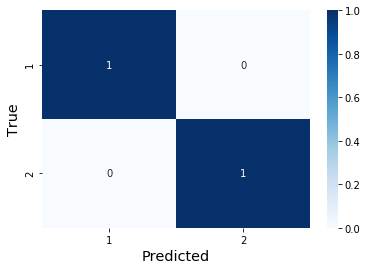

In [27]:
# Testing step 
Test_proj = pca.transform(Test)
Predicted_labels = classifier.predict(Test_proj)
# Test the predictions by making a correlation matrix
matrix_conf = confusion_matrix(Test_labels,Predicted_labels)
# Normalize confusion matrix
matrix_conf = matrix_conf.astype('float64') 
norm_fac = np.sum(matrix_conf[:], axis=1)
for row in range(matrix_conf.shape[0]):
    matrix_conf[row,:] = np.round(matrix_conf[row,:]*(1/norm_fac[row]),3)
# Plot confusion matrix    
sns_plot = sns.heatmap(matrix_conf, annot=True, cmap='Blues')
sns_plot.set(xticklabels=np.arange(1,5))
sns_plot.set(yticklabels=np.arange(1,5))
plt.ylabel('True', fontsize='x-large')
plt.xlabel('Predicted', fontsize='x-large')
sns_fig = sns_plot.get_figure()
sns_fig.savefig(output_dir+'/PCA_ML_StN150_Train_ConfMat.png')

In [10]:
# Save classifier
with open(output_dir+'/ML_pred_StN150.class', 'wb') as f:
    pickle.dump(classifier, f)
# Save PCA
with open(output_dir+'/PCA_StN150.class', 'wb') as f:
    pickle.dump(pca, f)
print('total variance explained: *.2E'%sum(pca.explained_variance_ratio_))

0.9999999885131563
